In [48]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import torchvision.transforms
import random
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2
from Model.load_dataVAE import *
from Model.VAE import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
train_loader, test_loader, val_loader,_ = loader()(subject= "ALL",
                                             batch_size= 30,
                                             use_cuda=True)

Train data shape:  (2115, 22, 1000)
Train labels shape:  (2115,)
test data shape:  (443, 22, 1000)
test labels shape:  (443,)


In [62]:
def loss_function(recon_x, x, mu, logvar):
    criterion = nn.MSELoss(reduction='sum')
    BCE = criterion(recon_x, x.view(-1, 22000))
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 22000), reduction='sum')

    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch, device):
    model.train()
    train_loss = 0
    latent = torch.tensor(np.array([]))
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
        latent = torch.cat((latent, model.Z_latent.double()), 0)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return latent
        

def test(epoch, device):
    model.eval()
    test_loss = 0
    latent = torch.tensor(np.array([]))
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            latent = torch.cat((latent, model.Z_latent.double()), 0)

    test_loss /= len(test_loader.dataset)
    print('====> test set loss: {:.4f}'.format(test_loss))
    return latent


In [66]:
def main_train(epoches = 10):
    device = torch.device("cpu")
    latent_train = torch.tensor(np.array([]))
    latent_test = torch.tensor(np.array([]))
    for epoch in range(1, epoches+1):
        latent_train = train(epoch,device)
        latent_test = test(epoch,device)
        if epoch == epoches:
            latent_train = latent_train.view(-1, 20, 20)
            latent_test = latent_test.view(-1, 20, 20)
            return latent_train, latent_test

In [25]:
device = torch.device("cpu")
train_loader, test_loader, val_loader,_ = loader()(subject= 1,
                                             batch_size= 30,
                                             num_validation =38,use_cuda=False)
model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 30)

Train data shape:  (199, 22, 1000)
Train labels shape:  (199,)
test data shape:  (50, 22, 1000)
test labels shape:  (50,)
Validation data shape:  (38, 22, 1000)
Validation labels shape:  (38,)
Train Epoch: 1 [0/199 (0%)]	Loss: 23953.806250
Train Epoch: 1 [150/199 (71%)]	Loss: 21814.770833
====> Epoch: 1 Average loss: 22958.7546
====> Validation set loss: 22568.9293
Train Epoch: 2 [0/199 (0%)]	Loss: 23619.870833
Train Epoch: 2 [150/199 (71%)]	Loss: 21021.764583
====> Epoch: 2 Average loss: 22527.0256
====> Validation set loss: 22191.4326
Train Epoch: 3 [0/199 (0%)]	Loss: 21197.347917
Train Epoch: 3 [150/199 (71%)]	Loss: 22539.258333
====> Epoch: 3 Average loss: 21864.0397
====> Validation set loss: 21654.8224
Train Epoch: 4 [0/199 (0%)]	Loss: 21482.404167
Train Epoch: 4 [150/199 (71%)]	Loss: 21107.900000
====> Epoch: 4 Average loss: 20706.6465
====> Validation set loss: 20757.3980
Train Epoch: 5 [0/199 (0%)]	Loss: 20847.033333
Train Epoch: 5 [150/199 (71%)]	Loss: 19291.158333
====> Epoc

In [77]:
device = torch.device("cpu")
train_loader, test_loader, val_loader,_ = loader()(subject= "ALL",
                                             batch_size= 30,
                                             use_cuda=False)
model = VAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
latent_train, latent_test = main_train(epoches = 10)

Train data shape:  (2115, 22, 1000)
Train labels shape:  (2115,)
test data shape:  (443, 22, 1000)
test labels shape:  (443,)
Train Epoch: 1 [0/2115 (0%)]	Loss: 21838.325000
Train Epoch: 1 [150/2115 (7%)]	Loss: 23985.291667
Train Epoch: 1 [300/2115 (14%)]	Loss: 20394.975000
Train Epoch: 1 [450/2115 (21%)]	Loss: 21924.116667
Train Epoch: 1 [600/2115 (28%)]	Loss: 23390.458333
Train Epoch: 1 [750/2115 (35%)]	Loss: 27807.572917
Train Epoch: 1 [900/2115 (42%)]	Loss: 20482.443750
Train Epoch: 1 [1050/2115 (49%)]	Loss: 25567.877083
Train Epoch: 1 [1200/2115 (56%)]	Loss: 25019.402083
Train Epoch: 1 [1350/2115 (63%)]	Loss: 20330.031250
Train Epoch: 1 [1500/2115 (70%)]	Loss: 24301.308333
Train Epoch: 1 [1650/2115 (77%)]	Loss: 21245.945833
Train Epoch: 1 [1800/2115 (85%)]	Loss: 22731.902083
Train Epoch: 1 [1950/2115 (92%)]	Loss: 21285.312500
Train Epoch: 1 [1050/2115 (99%)]	Loss: 23323.608333
====> Epoch: 1 Average loss: 21634.8221
====> test set loss: 19563.9090
Train Epoch: 2 [0/2115 (0%)]	Loss

Train Epoch: 10 [1500/2115 (70%)]	Loss: 11572.504167
Train Epoch: 10 [1650/2115 (77%)]	Loss: 10959.182292
Train Epoch: 10 [1800/2115 (85%)]	Loss: 9779.097917
Train Epoch: 10 [1950/2115 (92%)]	Loss: 11753.352083
Train Epoch: 10 [1050/2115 (99%)]	Loss: 11740.563542
====> Epoch: 10 Average loss: 10906.7079
====> test set loss: 12771.2312


In [78]:
print(latent_train.size())
print(latent_test.size())
np.save("latent_train.npy",latent_train.data.numpy())
np.save("latent_test.npy",latent_test.data.numpy())
c = np.load( "latent_train.npy" )
d = np.load( "latent_test.npy" )
print(c.shape)
print(d.shape)

torch.Size([2115, 20, 20])
torch.Size([443, 20, 20])
(2115, 20, 20)
(443, 20, 20)


In [87]:
from Model.load_dataVAE_CNN import *
from Model.VAE_ShallowCNN import *

In [80]:
train_loader, test_loader, val_loader, _ = loader()(subject = 1,
                                             batch_size= 30,
                                             num_validation =37)

Train data shape:  (200, 20, 20)
Train labels shape:  (200,)
test data shape:  (50, 20, 20)
test labels shape:  (50,)
Validation data shape:  (37, 20, 20)
Validation labels shape:  (37,)


In [82]:
criteria = F.cross_entropy

def train1(epoch,device):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criteria(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test1(test_loader=test_loader, mode = 'val',device=None):
    # train mode to get the train accuracy 
    # val mode to get the validation accuracy
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device).long()
            output = model(data)
            test_loss += criteria(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        
    test_loss /= len(test_loader.dataset)
    if mode == 'train':
        print('train loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

    else:
        print('validation loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    return [test_loss,correct / len(test_loader.dataset)]

In [83]:
def main_train(epoches = 8):
    stats = {}
    stats['train'] = []
    stats['val']  = []
    
    device = torch.device("cuda")

    epoches = range(epoches)
    for epoch in epoches:
        train1(epoch,device)
        stats['train'].append(test1(train_loader, mode='train',device=device))
        stats['val'].append(test1(val_loader, mode='val',device=device))

    print('Test set result:')
    test1(test_loader, mode = 'val',device=device)

    stats['val']  = np.array(stats['val'])
    stats['train'] = np.array(stats['train'])

    fig, ax = plt.subplots(1, 2,figsize = (8,4))
    ax[0].plot(epoches,stats['val'][:,0],epoches,stats['train'][:,0])

    ax[0].legend(['validation','train'])
    ax[0].set_title('loss')

    ax[1].plot(epoches,stats['val'][:,1],epoches,stats['train'][:,1])

    ax[1].legend(['validation','train'])
    ax[1].set_title('accuracy')

Train data shape:  (1773, 20, 20)
Train labels shape:  (1773,)
test data shape:  (443, 20, 20)
test labels shape:  (443,)
Validation data shape:  (342, 20, 20)
Validation labels shape:  (342,)
Train Epoch: 0 [0/1773 (0%)]	Loss: 1.374406
Train Epoch: 0 [150/1773 (8%)]	Loss: 1.375352
Train Epoch: 0 [300/1773 (17%)]	Loss: 1.388853
Train Epoch: 0 [450/1773 (25%)]	Loss: 1.370582
Train Epoch: 0 [600/1773 (33%)]	Loss: 1.409234
Train Epoch: 0 [750/1773 (42%)]	Loss: 1.363615
Train Epoch: 0 [900/1773 (50%)]	Loss: 1.393233
Train Epoch: 0 [1050/1773 (58%)]	Loss: 1.353279
Train Epoch: 0 [1200/1773 (67%)]	Loss: 1.379815
Train Epoch: 0 [1350/1773 (75%)]	Loss: 1.361860
Train Epoch: 0 [1500/1773 (83%)]	Loss: 1.390643
Train Epoch: 0 [1650/1773 (92%)]	Loss: 1.439255
train loss: 1.3791, Accuracy: 533/1773 (30%)
validation loss: 1.3864, Accuracy: 86/342 (25%)

Train Epoch: 1 [0/1773 (0%)]	Loss: 1.362750
Train Epoch: 1 [150/1773 (8%)]	Loss: 1.406488
Train Epoch: 1 [300/1773 (17%)]	Loss: 1.360149
Train Epoch

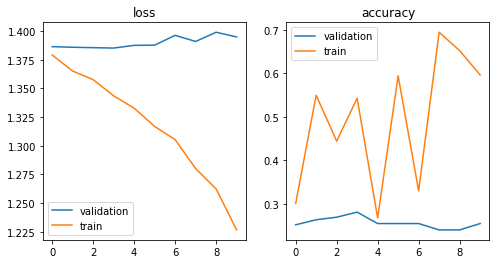

In [89]:
device = torch.device("cuda")
train_loader, test_loader, val_loader,_ = loader()(subject= "ALL",
                                             batch_size= 30,
                                             num_validation =38,use_cuda=True)
model = VAE_CNNShallow().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9,0.999), eps=1e-08, weight_decay=0.005)
main_train(epoches = 10)